In [58]:
# Copyright 2019 NeuroData (http://neurodata.io)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.




"""

mvmds.py

====================================


Classical Multiview Multidimensional Scaling

"""

import sys
sys.path.append("..")

from base import BaseEmbed
from utils.utils import check_Xs
import warnings


import numpy as np
from sklearn.metrics import euclidean_distances

class MVMDS(BaseEmbed):
    
    """"
    Classical Multiview Multidimensional Scaling for jointly reducing 
    the dimensions of multiple views of data. A euclidean distance matrix
    is created for each view, double centered, and the k largest common 
    eigenvectors are returned based on the algorithm proposed by the 
    following paper:

    https://www.sciencedirect.com/science/article/pii/S016794731000112X   



    """

    def _init_(self):

        super()._init_()
        self.components = None

    
    
    def _cpc(self,n_components,x):

        """
        Finds Stepwise Estimation of Common Principal Components as described by
        common Trendafilov implementations based on the following paper:

        https://www.sciencedirect.com/science/article/pii/S016794731000112X   


        Parameters
        ----------

        n_components: Number of dimensions to return

        x: List of matrices, each with number of rows, n

        it: Number of common principal component stepwise iterations
        
        Returns
        -------

        Components: Desired Common Principal Components

        """



        n = p = x.shape[1]

        views = len(x)

        n_num = np.array([n] * views)/np.sum(np.array([n] * views))

        Components = np.zeros((p,n_components)) 

        pi = np.eye(p)

        s = np.zeros((p,p))
        
        it = 15

        
        for i in np.arange(views):
            s = s + (n_num[i] * x[i])


        e1,e2 = np.linalg.eigh(s)


        q0 = e2[:,::-1] 


        for i in np.arange(n_components):

            q = q0[:,i]
            q = np.array(q).reshape(len(q),1)
            d = np.zeros((1,views))

            for j in np.arange(views):

                d[:,j] = np.dot(np.dot(q.T,x[j]),q)


            for j in np.arange(it):
                s2 = np.zeros((p,p))

                for yy in np.arange(views):
                    s2 = s2 + (n_num[yy]*np.sum(np.array([n] * views)) * x[yy] / d[:,yy])


                w = np.dot(s2,q) 

                w = np.dot(pi,w)

                q = w/ np.sqrt(np.dot(w.T,w))

                for yy in np.arange(views):

                    d[:,yy] = np.dot(np.dot(q.T,x[yy]),q)

            Components[:,i] = q[:,0]
            pi = pi - np.dot(q,q.T)


        return(Components)

   
    def fit(self,Xs,n_components):
        
        """
        
        Calculates a dimensional reduction based on minimizing Euclidean Distances of multiple views

        Parameters
        ----------

        Xs: list of array-likes
                - Xs shape: (n_views,)
                - Xs[i] shape: (n_samples, n_features_i)
                The data to fit to. Each sample will receive its own embedding.

        n_components: int (positive), optional, default = 0
            Number of components requested 

        Attributes
        ----------
        
        components: A k-dimensional projection of shape [n,k]

        """
    
        if (n_components) > len(Xs[0]):
            n_components = len(Xs[0])
            warnings.warn('The number of components you have requested is greater than the number of features in the dataset. '+ str(n_components) + " components were computed instead.")
            
        if (n_components) <= 0:
            raise ValueError("The number of components must be greater than 0 and less than the number of features")
        
        for i in Xs:
            for j  in Xs:
                if i.shape[0] != j.shape[0]:
                    raise ValueError("Input matrices must have the same number of samples")
        Xs = check_Xs(Xs,multiview = True)
    

        mat = np.ones(shape = (len(Xs),len(Xs[0]),len(Xs[0])))


        for i in range(len(Xs)):


            view = euclidean_distances(Xs[i])  
            view_squared = np.power(np.array(view),2)

            J = np.eye(len(view)) - (1/len(view))*np.ones(view.shape) #Centering matrix
            B = -(1/2) * np.matmul(np.matmul(J,view_squared),J)   #Double centered matrix B 
            mat[i] = B


        self.components = self._cpc(n_components,mat)
        
        return self.components


    def transform(self, Xs,n_components):
        """"
        Embeds data matrix(s) using fitted projection matrices
        
        Returns back the original Xs. Not needed for implementation
        
        
        Parameters
        ----------
        
        Xs: list of array-likes
            - Xs shape: (n_views,)
            - Xs[i] shape: (n_samples, n_features_i)
            The data to embed based on the prior fit function.

        """
        
        #if self.components is None:
        #    raise RuntimeError("Must call fit function before transform")
        
        Xs = check_Xs(Xs)
        
        
        
        return Xs
    
    
    def fit_transform(self, Xs,n_components):
        
        """"
        Embeds data matrix(s) using fitted projection matrices
        
        
        Parameters
        ----------
        
        Xs: list of array-likes
            - Xs shape: (n_views,)
            - Xs[i] shape: (n_samples, n_features_i)
            The data to embed based on the prior fit function.

        Returns
        -------
        
        Components: Components of the dimensionally reduced Xs
        
        """
        return self.fit(Xs,n_components)
    
            
        

In [59]:
     
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  

data_set = pd.read_csv('D:/Datasets/Diabetes_Dataset.csv', header = None)
data_set.columns = ['Pregnant','Plasma_Glucose','DBP','Thickness','Insulin','BMI','Pedigree','Age','Class']
X = data_set.loc[:,data_set.columns != 'Class']
y = data_set['Class']

V1_cols = ['Pregnant','Pedigree','Age','Plasma_Glucose','Thickness']
V2_cols = ['DBP','BMI','Insulin']


V1 = X[V1_cols] #First View
V2 = X[V2_cols]  #Second View

Views = [V1,V2]


In [60]:
V3 = V2.sample(14)
ju = [V1,V2,V3]

In [64]:
fit = MVMDS().fit(Views,100)

print(fit)

[[ 5.98941569e-03  4.49236555e-02  4.61642386e-02 ... -1.93618251e-03
  -1.94703889e-03  1.93045396e-03]
 [-3.79360572e-02 -1.73871396e-02  2.45925928e-02 ... -8.84135836e-06
  -4.97844153e-05  1.17138734e-04]
 [ 2.32332742e-02  8.38815675e-02 -2.82712392e-02 ... -1.53191755e-02
  -1.53480139e-02  1.53074054e-02]
 ...
 [ 6.38454418e-03 -8.89811887e-03  5.46207078e-04 ... -3.42440802e-03
  -3.43777798e-03  3.43463101e-03]
 [-1.42637717e-02  3.16924205e-02 -3.61645997e-02 ... -1.70518347e-02
  -1.70983453e-02  1.70119623e-02]
 [-3.25804262e-02 -1.15793880e-02  3.43033275e-02 ... -7.15233392e-03
  -7.17489765e-03  7.26652856e-03]]


In [65]:
fit.shape

(768, 100)

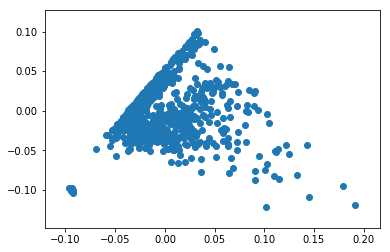

In [20]:
plt.scatter(fit[:,0],fit[:,1])

In [56]:
fit[0].shape

(768, 5)